In [182]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/week2/data/input')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # 사용 가능 모델 확인
# import torchvision

# for name in dir(torchvision.models):
#   print(name)
# # Load pretrained model
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model_loaded = torchvision.models.efficientnet_b0(weights=weights)
# # torchvision.models.efficientnet_b0(weights=torch.load('모델weights.pth'))

# ## 1. Model 변경
# # 1-1. Freeze layer
# for param in model_loaded.features.parameters():
#   param.requires_grad = False

# # 1-2. 특정 layer만 freeze
# for name, param in model_loaded.named_parameters(): # 각 layer의 이름과 맵피된 파라미터값 확인인
#   print('name : ', name)

# for name, param in model_loaded.named_parameters(): # 원하는 parameter name을 찾아 freeze
#   if name == 'features.2.0.block.3.0.weight':
#     param.requires_grad = False

# # 1-3. 학습시킬 parameter만 추려내기
# parameters_to_update = []
# for name, param in model_loaded.named_parameters():
#   if 'layer1' in name or 'layer2' in name:
#     parameters_to_update.append(param)

#   optimizer = optim.SGD(parameters_to_update, lr=0.001, momentum=0.9)

# ## 2. 모델 구조 바꾸기
# model_loaded.classifier = torch.nn.Sequential(
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(in_features=1280,
#               out_features=3)
# )

In [183]:
# List the images in the folder:
img_list = os.listdir()

input_images = []
for img in img_list:
    image = cv2.imread(img)
    input_images.append(image)

In [184]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [28]:
# # resize it to have a maximum width of 400 pixels
# for image in input_images:
#   image = imutils.resize(image, width=400)
#   (h, w) = image.shape[:2]
#   print(w,h)
#   cv2_imshow(image)

400 533


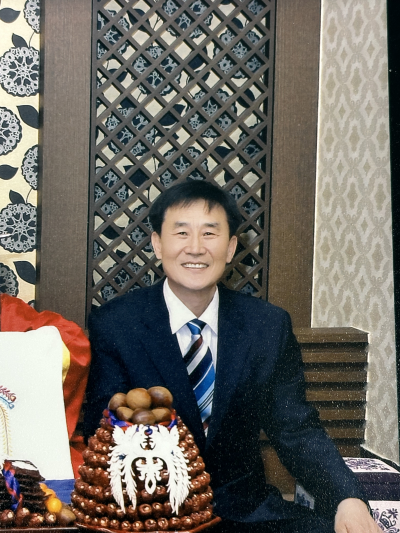

In [208]:
# resize it to have a maximum width of 400 pixels
image = input_images[0]
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

In [209]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2023-03-06 06:21:19--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2023-03-06 06:21:19 (21.0 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2023-03-06 06:21:20--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Load the pretrained face detection network model from disk

In [210]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


Use the dnn.blobFromImage functin to oconstruct an input blob by resizing the image to a fized 300*300 pixels and then normalizing it.

In [211]:
# # resize it to have a maximum width of 400 pixels
# for image in input_images:
#   image = imutils.resize(image, width=400)
#   blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [212]:
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

Pass the blob through the neural network and obtain the detections and predictions.

In [213]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Loop over the detections and draw boxes around the detected faces


In [214]:
trim_images = []
output_path = '../data/input_trim/'

for i in range(0, detections.shape[2]):
  # extract the confidence (i.e., probability) associated with the prediction
  confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
  if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box for the object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    startX, startY, endX, endY = box.astype("int")

    # save trimmed image
    img_trim = image[(startY-50):(endY+110), (startX-60):(endX+60)]
    output_name = output_path+'test.png'
    cv2.imwrite(output_name, img_trim)

		# draw the bounding box of the face along with the associated probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    # cv2.rectangle(image, (startX-60, startY-50), (endX+60, endY+110), (0, 0, 255), 2)
    # cv2.putText(image, text, (startX, y),
    # cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    


Show the resulting image

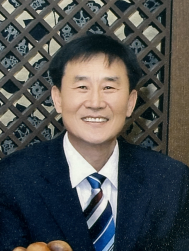

In [215]:
cv2_imshow(img_trim)

In [217]:
def crop_images(image, net):

  # resize it to have a maximum width of 400 pixels
  image = imutils.resize(image, width=400)
  (h, w) = image.shape[:2]
  # print(w,h)
  # cv2_imshow(image)
  image = imutils.resize(image, width=400)
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

  print("[INFO] computing object detections...")
  net.setInput(blob)
  detections = net.forward()

  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence threshold
    if confidence > 0.5:
      # compute the (x, y)-coordinates of the bounding box for the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      startX, startY, endX, endY = box.astype("int")
      
      # save trimmed image
      img_trim = image[(startY-50):(endY+110), (startX-60):(endX+60)]
      return img_trim

      # draw the bounding box of the face along with the associated probability
      # text = "{:.2f}%".format(confidence * 100)
      # y = startY - 10 if startY - 10 > 10 else startY + 10
      # cv2.rectangle(image, (startX-60, startY-50), (endX+60, endY+110), (0, 0, 255), 2)
      # cv2.putText(image, text, (startX, y),
      # cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

In [200]:
img_list[5][:-10] + 'trim.png'

'남성_39_trim.png'

In [233]:
print("[INFO] loading model...\n")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

output_path = '../input_trim/'
error_nbr = []
for idx, img in enumerate(input_images):
  output_name = output_path + img_list[idx][:-10] + 'trim.png'
  if img is not None:
    print(output_name)
    output = crop_images(img, net)
    try:
      cv2.imwrite(output_name, output)
    except Exception as e:
      print(e)
      error_nbr.append(img_list[idx])

[INFO] loading model...

../input_trim/남성_27_trim.png
[INFO] computing object detections...
../input_trim/남성_50_trim.png
[INFO] computing object detections...
../input_trim/남성_48_trim.png
[INFO] computing object detections...
../input_trim/남성_45_trim.png
[INFO] computing object detections...
OpenCV(4.6.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

../input_trim/남성_37_trim.png
[INFO] computing object detections...
OpenCV(4.6.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

../input_trim/남성_39_trim.png
[INFO] computing object detections...
../input_trim/남성_30_trim.png
[INFO] computing object detections...
../input_trim/남성_29_trim.png
[INFO] computing object detections...
../input_trim/여성_10_trim.png
[INFO] computing object detections...
../input_trim/여성_5_trim.png
[INFO] computing object detections...
..